In [1]:
#@title
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GaussianNoise
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from random import choice
from random import uniform
from numpy.random import randint
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


	

Train: X=(20, 28, 28), y=(20,)
Test: X=(1000, 28, 28), y=(1000,)


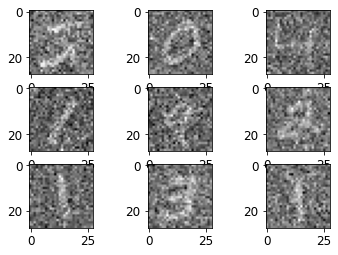

In [20]:
randseed = 42
(trainX, trainY), (testX, testY) = mnist.load_data()


# Pull only a subset of images 
# Using only 2500 images, might shrink 
trainX = trainX[:2500]
trainY = trainY[:2500]
testX = testX[:1000]
testY = testY[:1000]

trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
sample = GaussianNoise(0.6, seed=randseed)
trainX = sample(trainX, training=True)
testX = sample(testX, training=True)
trainX = trainX.numpy()
testX = testX.numpy()
trainX = trainX.astype('float32') * 255
testX = testX.astype('float32') * 255


# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

Preprocess the dataset, reshape the images to a single color channel 

and "one hot" encode the y_lablels
i.e. the label '3' -> [0,0,0,1,0,0,0,0,0,0] 

In [21]:
# Preprocess train and test dataset
def PreProcess(trainX, trainY, testX, testY, ds="MNIST"):
    #convert single color channel
    if ds=="MNIST":
        trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
        testX = testX.reshape((testX.shape[0], 28, 28, 1))

    #one hot encode labels
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [22]:
# scale pixels
def PrepPixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [23]:
trainX, trainY, testX, testY = PreProcess(trainX, trainY, testX, testY)
	# prepare pixel data
trainX, testX = PrepPixels(trainX, testX)

In [24]:
def CNN_MNIST(f1, k, a1, a2):
	model = Sequential()
	model.add(Conv2D(filters=f1, kernel_size=(k, k), activation=a1, kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation=a2, kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))

	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	#es = EarlyStopping(monitor="val_accuracy", patience = 7)
	#model.fit(trainX, trainY, validation_data=(testX, testY), epochs=10, batch_size = 32, verbose=0)

	return model

In [25]:
def CreateParamGrid_MNIST():
    f1 = [32, 64]
    k = [3,5]
    a1 = ["relu", "selu", "elu"]
    a2 = ["relu", "selu", "elu"]
    #op = ["adamax", "adadelta", "adam", "adagrad"]
    
    return dict(f1 = f1,  k = k, a1 = a1, a2 = a2)

In [26]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# Fitness evaluation metric: Classification Accuracy 
def fitness_evaluation(model, test_images, test_labels):
  #metrics = model.evaluate(test_images, test_labels)
  y_pred = model.predict(test_images)
  #Class balanced accuracy
  y_pred = np.argmax(y_pred, axis=1)
  y_true = np.argmax(test_labels, axis=1)
  acc  = balanced_accuracy_score(y_true, y_pred=y_pred)
  return acc

In [27]:

num_threads = 3 # -1 for as many as possible

model = KerasClassifier(build_fn=CNN_MNIST, verbose=0)
param_grid = CreateParamGrid_MNIST()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=num_threads, cv=5, verbose=5)
grid_result = grid.fit(trainX, trainY)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-27-12648287255d>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=CNN_MNIST, verbose=0)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   25.6s
[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:   27.3s finished


Best: 0.200000 using {'a1': 'selu', 'a2': 'elu', 'f1': 64, 'k': 5}
0.050000 (0.050000) with: {'a1': 'relu', 'a2': 'relu', 'f1': 32, 'k': 3}
0.050000 (0.050000) with: {'a1': 'relu', 'a2': 'relu', 'f1': 32, 'k': 5}
0.050000 (0.050000) with: {'a1': 'relu', 'a2': 'relu', 'f1': 64, 'k': 3}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'relu', 'f1': 64, 'k': 5}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'selu', 'f1': 32, 'k': 3}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'selu', 'f1': 32, 'k': 5}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'selu', 'f1': 64, 'k': 3}
0.050000 (0.050000) with: {'a1': 'relu', 'a2': 'selu', 'f1': 64, 'k': 5}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'elu', 'f1': 32, 'k': 3}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'elu', 'f1': 32, 'k': 5}
0.100000 (0.000000) with: {'a1': 'relu', 'a2': 'elu', 'f1': 64, 'k': 3}
0.050000 (0.050000) with: {'a1': 'relu', 'a2': 'elu', 'f1': 64, 'k': 5}
0.100000 (0.000000) with: {'a1': 'selu', 'a2': 'relu', 'f1': 

In [32]:
#Best: 1.000000 using {'a1': 'relu', 'a2': 'selu', 'f1': 32, 'k': 5, 'op': 'adadelta'}
best_params = grid_result.best_params_
f1 = best_params["f1"]
k = best_params["k"]
a1 = best_params["a1"]
a2 = best_params["a2"]
#op = best_params["op"]
model = CNN_MNIST(f1, k, a1, a2)
y_score = model.predict(testX)
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(testY, axis=1)
acc = fitness_evaluation(model, testX, testY)
print("Best accuracy using the selected parameters {}".format(acc))

Best accuracy using the selected parameters 0.0892184217558608


In [33]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[15,  0,  2,  0,  0,  6, 33,  0,  0, 29],
       [12,  0,  0,  2,  0, 21, 35,  2,  1, 53],
       [24,  0,  3,  0,  0, 15, 18,  0,  0, 56],
       [29,  0,  3,  0,  0, 12, 25,  0,  1, 37],
       [19,  1,  1,  0,  0,  9, 36,  2,  0, 42],
       [25,  0,  0,  0,  0,  9, 29,  0,  1, 23],
       [18,  0,  1,  1,  0,  9, 27,  0,  0, 31],
       [28,  0,  3,  0,  0,  8, 33,  1,  0, 26],
       [17,  0,  0,  1,  0, 17, 29,  1,  0, 24],
       [32,  0,  1,  0,  0, 17, 18,  1,  0, 25]], dtype=int64)

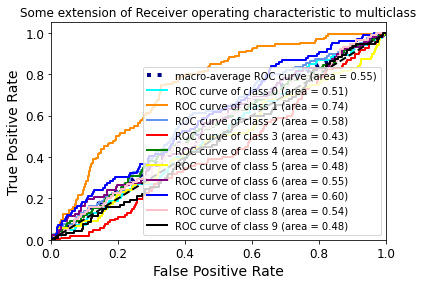

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
n_classes = 10
lw = 2


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
#plt.plot(
#    fpr["micro"],
#    tpr["micro"],
#    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#    color="deeppink",
#    linestyle=":",
#    linewidth=4,
#)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "yellow", "purple", "blue", "pink", "black"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()


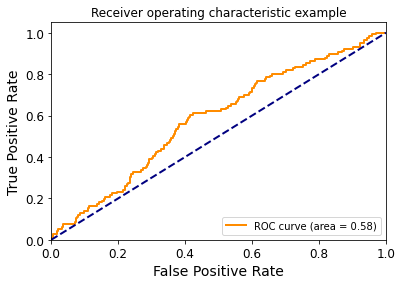

In [35]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()